In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from tensorflow.keras.optimizers import Adam

2023-11-27 20:11:09.015081: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-27 20:11:18.933863: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-11-27 20:11:18.934091: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-11-27 20:11:18.934105: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like t

In [4]:
import os

df = pd.read_csv("ml.csv")

In [39]:

df = df.sort_values(by=['subreddit', 'year', 'month'])
df_sub = df[df["subreddit"] == "FinalFantasy"]
def model_predict(data,name):


# Pivot the DataFrame to have 'subreddit' as columns and 'year-month' as index
    df_pivot = data.pivot_table(index=['year', 'month'], columns='subreddit', values='post_count', aggfunc='sum', fill_value=0)

# Convert the index to datetime
    df_pivot.index = pd.to_datetime(df_pivot.index.map(lambda x: '-'.join(map(str, x))))

# Normalize the data using Min-Max scaling
    scaler = MinMaxScaler()
    df_scaled = pd.DataFrame(scaler.fit_transform(df_pivot), index=df_pivot.index)

# Prepare input sequences and labels
    sequence_length = 3  # You can adjust this based on your requirements

    X, y = [], []
    for i in range(len(df_scaled) - sequence_length):
        X.append(df_scaled.iloc[i:i+sequence_length].values)
        y.append(df_scaled.iloc[i+sequence_length].values)

    X = np.array(X)
    y = np.array(y)
    split = int(0.8 * len(X))
    X_train, X_test, y_train, y_test = X[:split], X[split:], y[:split], y[split:]

    model = Sequential()
    model.add(SimpleRNN(units=50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dense(units=1, activation='linear'))

# Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')  # Mean Squared Error is a common loss function for regression problems

    model.fit(X_train, y_train, epochs=50, batch_size=32)

    loss = model.evaluate(X_test, y_test)
 

    # Make predictions
    predictions = model.predict(X_test)

    # Inverse transform the predictions and actual values to the original scale
    predictions = scaler.inverse_transform(predictions)
    y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

    predictions = []

    last_months = df_scaled.tail(sequence_length).values

# Generate date indices for the next three months starting from the last date in the original data
    next_months_index = pd.date_range(df_scaled.index[-1], periods=7, freq='MS')[1:]

    for i in range(6):  # Predict for the next three months
    # Reshape the last_months array to match the input shape of the model
        last_months_reshaped = last_months.reshape((1, sequence_length, df_scaled.shape[1]))

    # Predict the next month
        predicted_scaled = model.predict(last_months_reshaped)

    # Inverse transform the predicted values to the original scale
        predicted = scaler.inverse_transform(predicted_scaled)

    # Append the predicted value to the list of predictions
        predictions.append(predicted[0])

    # Update the input sequence for the next iteration
        last_months = np.vstack([last_months[1:], predicted_scaled])

# Convert the predictions list to a NumPy array
    predictions = np.array(predictions)

# Create a DataFrame with the predicted values and the new date indices
    predicted_df = pd.DataFrame(predictions, index=next_months_index, columns=df_scaled.columns)
    last_row_df_pivot = df_pivot.iloc[-1:]

# Append the last row to predicted_df
    predicted_df = pd.concat([predicted_df, last_row_df_pivot])
    # Plot the original data
    plt.figure(figsize=(12, 6))
    plt.plot(df_pivot.index, df_pivot[name], label='Original Data', marker='o')

# Plot the predicted data for the next three months
    plt.plot(predicted_df.index, predicted_df[0], label='Predicted Data', marker='o')

    plt.title('Original vs Predicted GTA Posts Count')
    plt.xlabel('Date')
    plt.ylabel('Posts Count')
    plt.legend()
    plt.show()


Epoch 1/50
1/1 [==============================] - 1s 818ms/step - loss: 0.1486
Epoch 2/50
1/1 [==============================] - 0s 5ms/step - loss: 0.1359
Epoch 3/50
1/1 [==============================] - 0s 4ms/step - loss: 0.1238
Epoch 4/50
1/1 [==============================] - 0s 4ms/step - loss: 0.1129
Epoch 5/50
1/1 [==============================] - 0s 4ms/step - loss: 0.1029
Epoch 6/50
1/1 [==============================] - 0s 4ms/step - loss: 0.0939
Epoch 7/50
1/1 [==============================] - 0s 4ms/step - loss: 0.0861
Epoch 8/50
1/1 [==============================] - 0s 4ms/step 

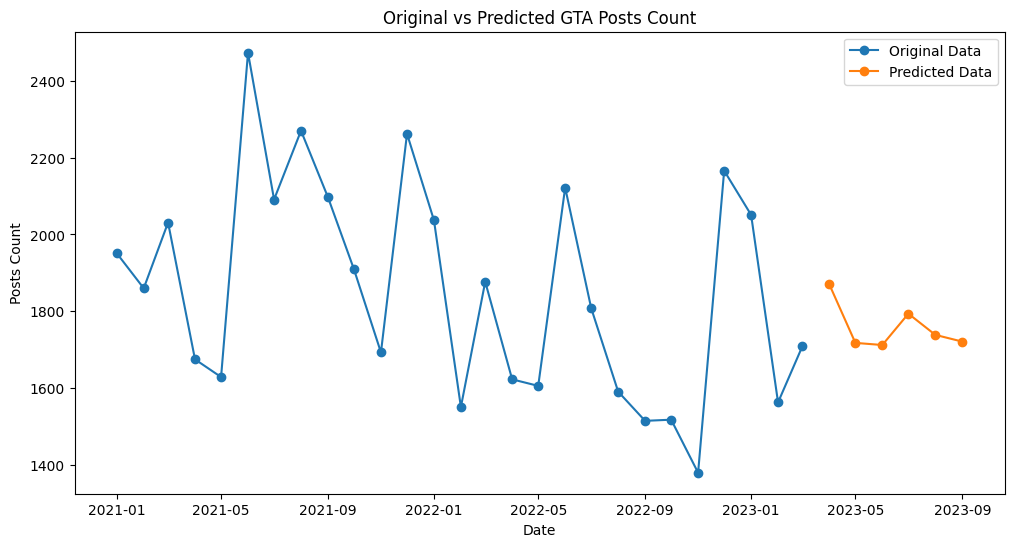

In [40]:
model_predict(df_sub,"FinalFantasy")

In [88]:
times = df_pivot.index.values[3:]
times.shape

(24,)

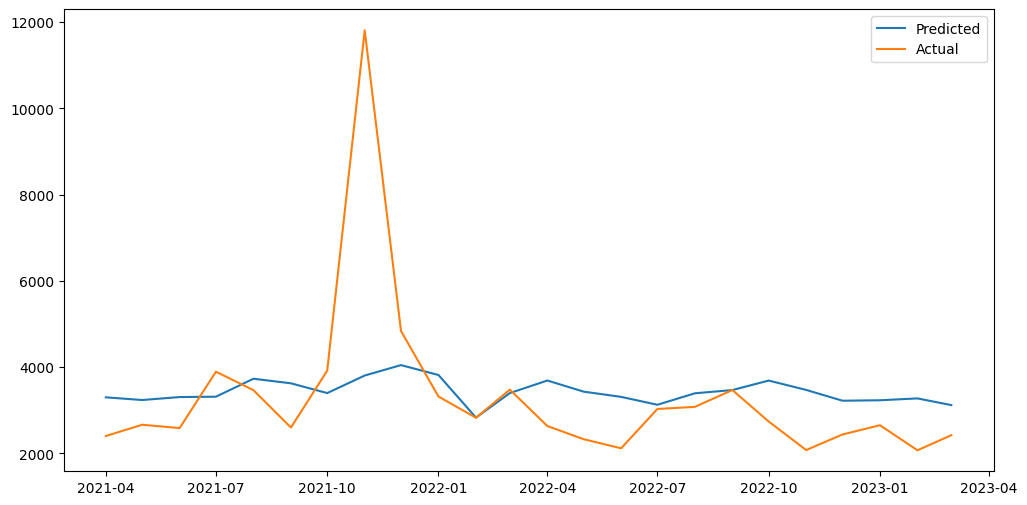

In [96]:
# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(times, predictions, label='Predicted')
plt.plot(times, y_test_actual, label='Actual')
plt.legend()
plt.show()

In [ ]:
df_pivot